In [1]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
from torch.autograd import Variable
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from PIL import Image
plt.rcParams['figure.figsize'] = 15, 10

# 生成测试数据

In [3]:
DEBUG = False
# 取出文本框
def get_text_rect(image):
    img = image.copy()

    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img,(21,7),0)


    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)
    # plt.imshow(img,'gray')
    # plt.show()

    element = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
    img = cv2.erode(img, element)
    # plt.imshow(img,'gray')
    # plt.show()

    img = cv2.dilate(img, element)
    if DEBUG:
        plt.imshow(img,'gray')
        plt.show()

    img = cv2.blur(img, tuple((5, 5)))
    if DEBUG:
        plt.imshow(img,'gray')
        plt.show()
    
    # 去黑边
    vertical = np.copy(img)
    cols = vertical.shape[1]
    vertical_size = int(cols / 40)
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vertical_size))
    vertical = cv2.erode(vertical, verticalStructure)
    vertical = cv2.dilate(vertical, verticalStructure)

    vertical = cv2.blur(vertical, tuple((3, 3)))
    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((17, 17)), (-1, -1))
    vertical = cv2.dilate(vertical, element, iterations=1)
    vertical = cv2.bitwise_not(vertical)
    img = cv2.bitwise_and(img,vertical)    
    if DEBUG:
        plt.imshow(img,'gray')
        plt.show()    

    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((13, 5)), (-1, -1))
    img = cv2.dilate(img, element, iterations=2)
    if DEBUG:
        plt.imshow(img,'gray')
        plt.show()
    
    nimg, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    # print(contours)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w > 150 and w < 400:
            cnts.append([y,x,h,w])
    return cnts

# 取出字符文档框
def get_char_rect(image):
    img = image.copy()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img,(5,5),0)
    img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)
    if DEBUG:
        plt.imshow(img,'gray')
        plt.show()
        
    # 去燥点
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img = cv2.erode(img, element)
    img = cv2.dilate(img, element)
    
    
    img = cv2.blur(img, tuple((3, 3)))
    element = cv2.getStructuringElement(cv2.MORPH_RECT, tuple((3, 3)), (-1, -1))
    img = cv2.dilate(img, element, iterations=1)
    
    nimg, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        if w >= 30:
            cnts.append([y,x,h,w])
    return cnts

# 对文本框位置列表信息按Y、X坐标点进行排序
# rect_list: 边框（y,x,h,w)位置列表， 类型 list
# 返回排序号的rect_list, 类型list
def text_rect_sort(rect_list):
    rects = np.array(rect_list)
    print('y mean --> {}'.format(np.mean(rects[:,0])))
    print('y std --> {}'.format(np.std(rects[:,0])))
    
    if np.std(rects[:,0]) < 10:
        # std 小于10 表明数据在一行，不需再作特殊处理
        ridx = np.lexsort([rects[:,1]])
        rects = rects[ridx]    
    else:
        ridx = np.lexsort([rects[:,1],rects[:,0]])
        rects = rects[ridx]
        # 对边框按坐标点Y进行区间划分
        rect_area = (rects[:, 0] - rects[0][0])/ np.std(rects[:, 0],ddof=1)
        rect_area = np.around(rect_area,1) 

        rect_current_class = 0
        rect_class = [rect_current_class]
        for inx in range(1, len(rect_area)):
            if abs(rect_area[inx] - rect_area[inx-1]) > 0.5:
                rect_current_class = rect_current_class + 1
            rect_class.append(rect_current_class)        

        rects = np.insert(rects,4,values=np.array(rect_class),axis=1)
        ridx = np.lexsort([rects[:,1],rects[:,4]])
        rects = rects[ridx]
    return rects[:,0:4].tolist()

def answer_bind_rect(rect_list, answer_list):
    rect_len = len(rect_list)
    answer_len = len(answer_list)
    answers = {answer_list[answer_len-idx-1]:rect_list[rect_len-idx -1] for idx in range(answer_len)}
    return answers
    

------------ 开始处理 360n4s -----------------
[[2282, 846, 31, 412], [2287, 378, 30, 416], [2365, 844, 30, 413], [2370, 375, 30, 417], [2446, 842, 31, 414], [2452, 372, 31, 418], [2529, 840, 31, 416], [2535, 370, 32, 418], [2613, 839, 30, 415], [2618, 368, 33, 419]]
[[1120, 312, 298, 1816], [1418, 309, 381, 1816], [1799, 299, 300, 1825], [2099, 291, 553, 1834], [2652, 275, 483, 1853]]


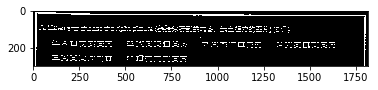

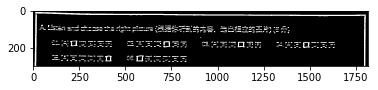

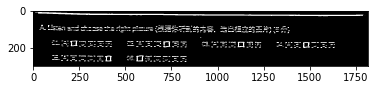

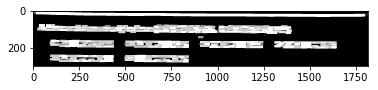

y mean --> 183.5
y std --> 36.16973873281365
[[153, 88, 47, 353], [157, 495, 46, 352], [160, 901, 44, 350], [162, 1306, 44, 343], [234, 89, 46, 351], [235, 494, 47, 353]]
{6: [235, 494, 47, 353], 5: [234, 89, 46, 351], 4: [162, 1306, 44, 343], 3: [160, 901, 44, 350], 2: [157, 495, 46, 352], 1: [153, 88, 47, 353]}


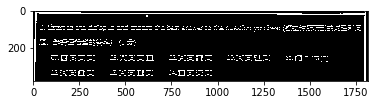

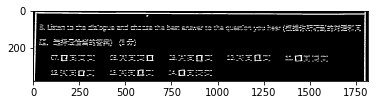

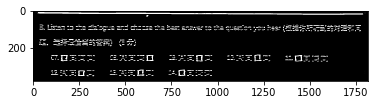

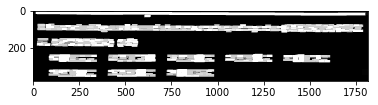

y mean --> 264.75
y std --> 38.93825240043523
[[235, 84, 46, 265], [235, 404, 45, 264], [235, 724, 47, 262], [233, 1039, 48, 262], [235, 1353, 48, 260], [317, 83, 44, 264], [314, 402, 46, 265], [314, 721, 46, 263]]
{14: [314, 721, 46, 263], 13: [314, 402, 46, 265], 12: [317, 83, 44, 264], 11: [235, 1353, 48, 260], 10: [233, 1039, 48, 262], 9: [235, 724, 47, 262], 8: [235, 404, 45, 264], 7: [235, 84, 46, 265]}


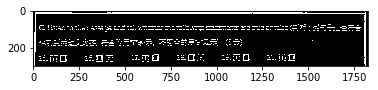

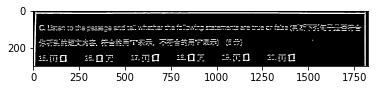

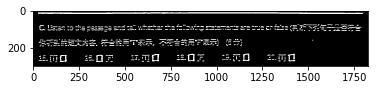

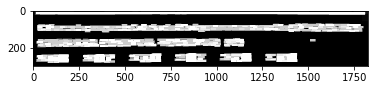

y mean --> 230.83333333333334
y std --> 2.6718699236468995
[[235, 16, 51, 182], [234, 268, 51, 182], [230, 519, 53, 184], [229, 769, 52, 178], [228, 1015, 52, 179], [229, 1263, 52, 180]]
{20: [229, 1263, 52, 180], 19: [228, 1015, 52, 179], 18: [229, 769, 52, 178], 17: [230, 519, 53, 184], 16: [234, 268, 51, 182], 15: [235, 16, 51, 182]}


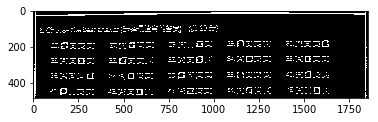

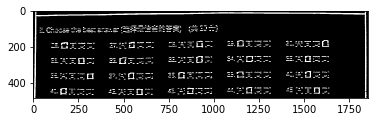

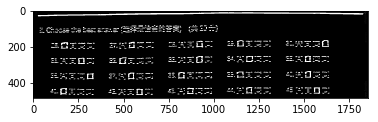

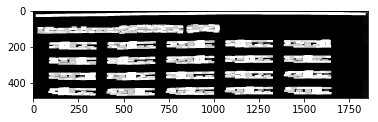

y mean --> 282.0
y std --> 104.33553930423115
[[75, 847, 54, 189], [171, 86, 48, 269], [168, 410, 51, 272], [163, 736, 50, 270], [160, 1061, 48, 268], [159, 1384, 50, 268], [256, 85, 47, 268], [253, 407, 50, 272], [246, 734, 51, 271], [246, 1060, 47, 269], [245, 1384, 47, 267], [341, 84, 46, 266], [338, 405, 50, 273], [335, 733, 47, 272], [332, 1059, 47, 271], [329, 1385, 49, 268], [422, 82, 50, 268], [426, 403, 47, 273], [421, 731, 48, 273], [417, 1058, 49, 272], [419, 1387, 47, 268]]
{45: [419, 1387, 47, 268], 44: [417, 1058, 49, 272], 43: [421, 731, 48, 273], 42: [426, 403, 47, 273], 41: [422, 82, 50, 268], 40: [329, 1385, 49, 268], 39: [332, 1059, 47, 271], 38: [335, 733, 47, 272], 37: [338, 405, 50, 273], 36: [341, 84, 46, 266], 35: [245, 1384, 47, 267], 34: [246, 1060, 47, 269], 33: [246, 734, 51, 271], 32: [253, 407, 50, 272], 31: [256, 85, 47, 268], 30: [159, 1384, 50, 268], 29: [160, 1061, 48, 268], 28: [163, 736, 50, 270], 27: [168, 410, 51, 272], 26: [171, 86, 48, 269]}
----

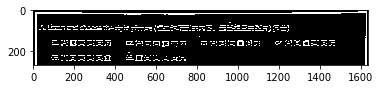

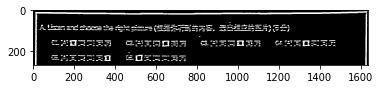

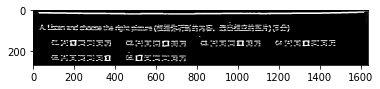

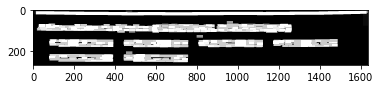

y mean --> 162.83333333333334
y std --> 31.114930321131826
[[140, 77, 42, 318], [142, 440, 42, 321], [142, 805, 41, 320], [140, 1170, 42, 321], [213, 76, 41, 318], [200, 439, 55, 321]]
{6: [200, 439, 55, 321], 5: [213, 76, 41, 318], 4: [140, 1170, 42, 321], 3: [142, 805, 41, 320], 2: [142, 440, 42, 321], 1: [140, 77, 42, 318]}


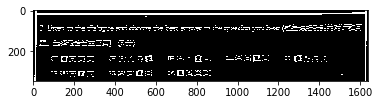

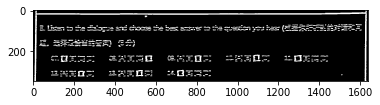

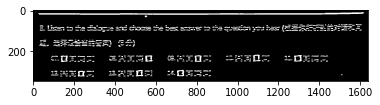

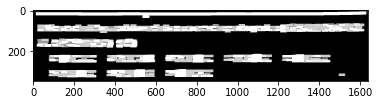

y mean --> 228.77777777777777
y std --> 46.60895902858586
[[137, 16, 47, 381], [215, 75, 43, 239], [214, 359, 42, 240], [213, 644, 44, 241], [210, 929, 46, 242], [212, 1215, 44, 242], [289, 74, 40, 238], [285, 357, 43, 241], [284, 643, 43, 241]]
{14: [284, 643, 43, 241], 13: [285, 357, 43, 241], 12: [289, 74, 40, 238], 11: [212, 1215, 44, 242], 10: [210, 929, 46, 242], 9: [213, 644, 44, 241], 8: [214, 359, 42, 240], 7: [215, 75, 43, 239]}


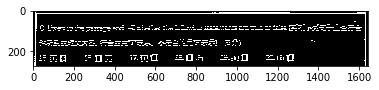

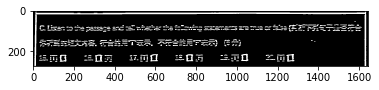

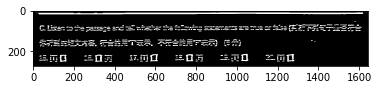

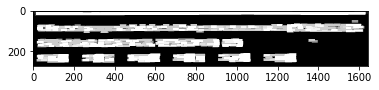

y mean --> 208.33333333333334
y std --> 1.699673171197595
[[211, 16, 46, 163], [210, 236, 47, 166], [208, 459, 48, 168], [208, 683, 47, 164], [206, 905, 49, 165], [207, 1128, 49, 168]]
{20: [207, 1128, 49, 168], 19: [206, 905, 49, 165], 18: [208, 683, 47, 164], 17: [208, 459, 48, 168], 16: [210, 236, 47, 166], 15: [211, 16, 46, 163]}


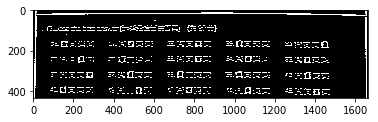

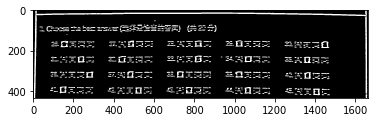

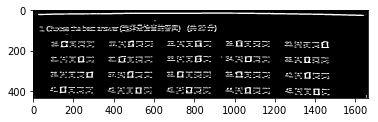

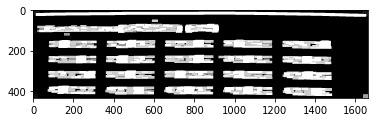

y mean --> 251.1904761904762
y std --> 93.47147211728957
[[66, 752, 49, 173], [146, 76, 45, 243], [145, 363, 46, 246], [145, 652, 44, 246], [144, 943, 45, 246], [148, 1234, 46, 249], [222, 74, 44, 243], [221, 360, 45, 246], [219, 652, 46, 246], [222, 918, 43, 271], [225, 1235, 45, 247], [299, 73, 42, 241], [297, 358, 45, 247], [297, 650, 44, 247], [298, 941, 45, 249], [301, 1236, 47, 248], [372, 70, 46, 243], [377, 356, 43, 247], [375, 648, 44, 248], [375, 941, 47, 250], [381, 1237, 46, 249]]
{45: [381, 1237, 46, 249], 44: [375, 941, 47, 250], 43: [375, 648, 44, 248], 42: [377, 356, 43, 247], 41: [372, 70, 46, 243], 40: [301, 1236, 47, 248], 39: [298, 941, 45, 249], 38: [297, 650, 44, 247], 37: [297, 358, 45, 247], 36: [299, 73, 42, 241], 35: [225, 1235, 45, 247], 34: [222, 918, 43, 271], 33: [219, 652, 46, 246], 32: [221, 360, 45, 246], 31: [222, 74, 44, 243], 30: [148, 1234, 46, 249], 29: [144, 943, 45, 246], 28: [145, 652, 44, 246], 27: [145, 363, 46, 246], 26: [146, 76, 45, 243]}
-

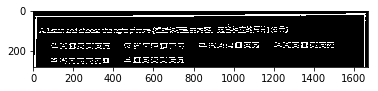

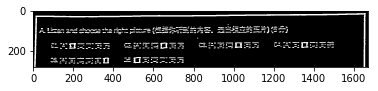

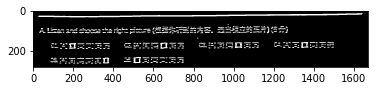

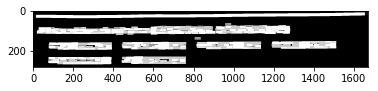

y mean --> 175.0
y std --> 35.05709628591621
[[153, 76, 42, 320], [151, 441, 43, 326], [150, 813, 42, 327], [147, 1187, 43, 327], [226, 74, 42, 320], [223, 440, 43, 325]]
{6: [223, 440, 43, 325], 5: [226, 74, 42, 320], 4: [147, 1187, 43, 327], 3: [150, 813, 42, 327], 2: [151, 441, 43, 326], 1: [153, 76, 42, 320]}


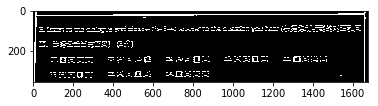

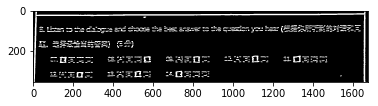

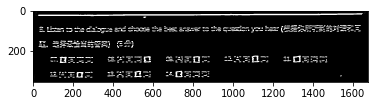

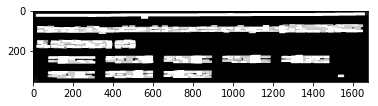

y mean --> 235.0
y std --> 47.60252094164762
[[142, 14, 47, 385], [222, 73, 43, 241], [219, 360, 44, 244], [219, 651, 45, 247], [216, 943, 46, 248], [216, 1238, 46, 247], [297, 71, 41, 241], [292, 358, 45, 245], [292, 650, 44, 246]]
{14: [292, 650, 44, 246], 13: [292, 358, 45, 245], 12: [297, 71, 41, 241], 11: [216, 1238, 46, 247], 10: [216, 943, 46, 248], 9: [219, 651, 45, 247], 8: [219, 360, 44, 244], 7: [222, 73, 43, 241]}


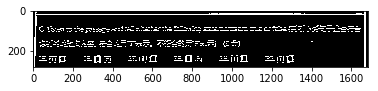

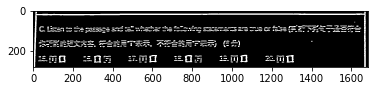

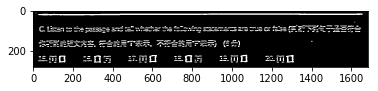

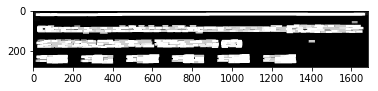

y mean --> 215.66666666666666
y std --> 1.3743685418725538
[[218, 11, 48, 167], [217, 237, 49, 169], [215, 465, 50, 172], [215, 695, 49, 168], [214, 923, 50, 170], [215, 1154, 50, 172]]
{20: [215, 1154, 50, 172], 19: [214, 923, 50, 170], 18: [215, 695, 49, 168], 17: [215, 465, 50, 172], 16: [217, 237, 49, 169], 15: [218, 11, 48, 167]}


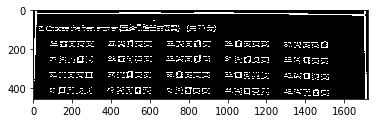

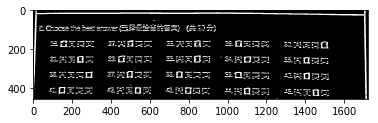

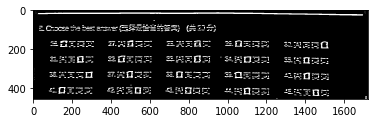

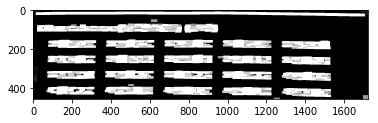

y mean --> 260.6190476190476
y std --> 96.69612499769141
[[69, 776, 49, 178], [151, 75, 46, 252], [149, 373, 47, 253], [150, 673, 45, 254], [150, 973, 47, 254], [155, 1276, 48, 257], [230, 73, 46, 251], [228, 371, 47, 253], [227, 671, 48, 254], [232, 948, 45, 280], [236, 1277, 47, 255], [310, 70, 45, 251], [307, 368, 47, 255], [308, 670, 47, 255], [311, 971, 48, 257], [315, 1277, 50, 257], [388, 67, 47, 252], [377, 366, 58, 254], [390, 667, 47, 256], [392, 971, 48, 257], [398, 1277, 50, 258]]
{45: [398, 1277, 50, 258], 44: [392, 971, 48, 257], 43: [390, 667, 47, 256], 42: [377, 366, 58, 254], 41: [388, 67, 47, 252], 40: [315, 1277, 50, 257], 39: [311, 971, 48, 257], 38: [308, 670, 47, 255], 37: [307, 368, 47, 255], 36: [310, 70, 45, 251], 35: [236, 1277, 47, 255], 34: [232, 948, 45, 280], 33: [227, 671, 48, 254], 32: [228, 371, 47, 253], 31: [230, 73, 46, 251], 30: [155, 1276, 48, 257], 29: [150, 973, 47, 254], 28: [150, 673, 45, 254], 27: [149, 373, 47, 253], 26: [151, 75, 46, 252]}
-

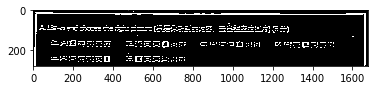

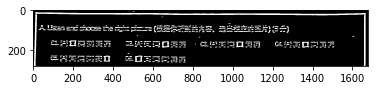

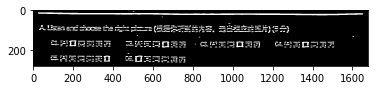

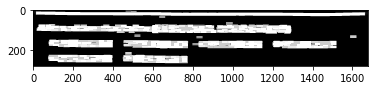

y mean --> 170.16666666666666
y std --> 30.926885103776975
[[145, 76, 43, 327], [148, 451, 45, 328], [150, 796, 42, 356], [151, 1198, 42, 325], [220, 74, 42, 327], [207, 448, 59, 329]]
{6: [207, 448, 59, 329], 5: [220, 74, 42, 327], 4: [151, 1198, 42, 325], 3: [150, 796, 42, 356], 2: [148, 451, 45, 328], 1: [145, 76, 43, 327]}


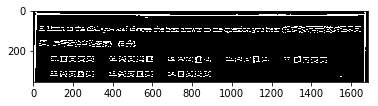

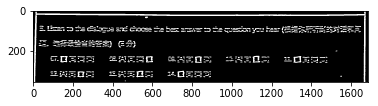

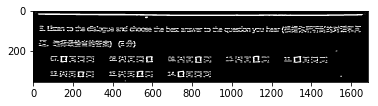

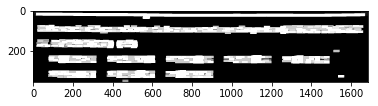

y mean --> 236.0
y std --> 48.29078587059855
[[139, 14, 50, 396], [220, 75, 44, 247], [221, 370, 43, 248], [221, 666, 45, 245], [219, 956, 46, 247], [220, 1250, 46, 245], [296, 73, 42, 248], [294, 368, 44, 249], [294, 663, 44, 246]]
{14: [294, 663, 44, 246], 13: [294, 368, 44, 249], 12: [296, 73, 42, 248], 11: [220, 1250, 46, 245], 10: [219, 956, 46, 247], 9: [221, 666, 45, 245], 8: [221, 370, 43, 248], 7: [220, 75, 44, 247]}


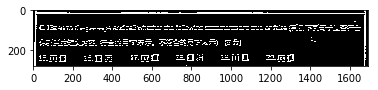

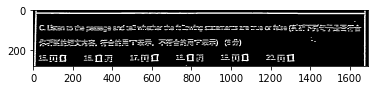

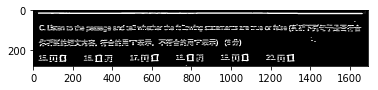

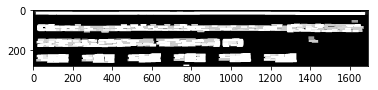

y mean --> 215.0
y std --> 1.8257418583505538
[[218, 14, 48, 169], [217, 243, 50, 172], [214, 476, 51, 173], [214, 708, 49, 167], [213, 935, 50, 169], [214, 1164, 50, 171]]
{20: [214, 1164, 50, 171], 19: [213, 935, 50, 169], 18: [214, 708, 49, 167], 17: [214, 476, 51, 173], 16: [217, 243, 50, 172], 15: [218, 14, 48, 169]}


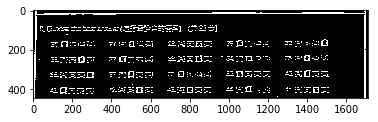

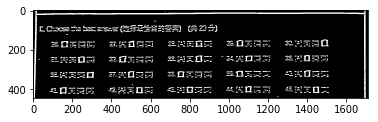

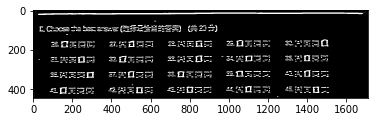

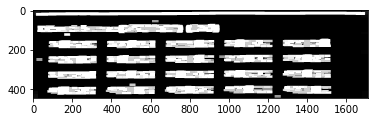

y mean --> 254.66666666666666
y std --> 94.25817298570546
[[68, 777, 50, 178], [151, 78, 45, 251], [150, 376, 46, 252], [149, 675, 45, 252], [146, 974, 45, 251], [143, 1273, 48, 250], [229, 76, 45, 252], [226, 374, 47, 253], [224, 673, 47, 254], [225, 948, 44, 277], [222, 1273, 45, 248], [307, 75, 44, 250], [304, 372, 46, 254], [304, 673, 44, 253], [302, 972, 44, 253], [299, 1272, 47, 251], [385, 71, 47, 254], [371, 370, 58, 255], [382, 671, 45, 254], [379, 971, 46, 254], [382, 1273, 45, 252]]
{45: [382, 1273, 45, 252], 44: [379, 971, 46, 254], 43: [382, 671, 45, 254], 42: [371, 370, 58, 255], 41: [385, 71, 47, 254], 40: [299, 1272, 47, 251], 39: [302, 972, 44, 253], 38: [304, 673, 44, 253], 37: [304, 372, 46, 254], 36: [307, 75, 44, 250], 35: [222, 1273, 45, 248], 34: [225, 948, 44, 277], 33: [224, 673, 47, 254], 32: [226, 374, 47, 253], 31: [229, 76, 45, 252], 30: [143, 1273, 48, 250], 29: [146, 974, 45, 251], 28: [149, 675, 45, 252], 27: [150, 376, 46, 252], 26: [151, 78, 45, 251]}


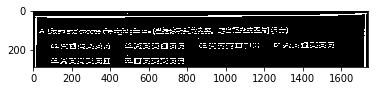

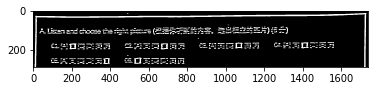

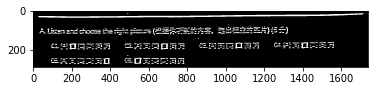

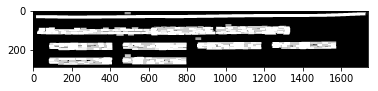

y mean --> 183.0
y std --> 33.54598833442433
[[162, 81, 43, 334], [162, 463, 43, 338], [158, 850, 44, 339], [156, 1238, 44, 340], [237, 80, 44, 334], [223, 462, 56, 338]]
{6: [223, 462, 56, 338], 5: [237, 80, 44, 334], 4: [156, 1238, 44, 340], 3: [158, 850, 44, 339], 2: [162, 463, 43, 338], 1: [162, 81, 43, 334]}


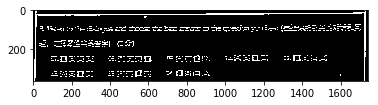

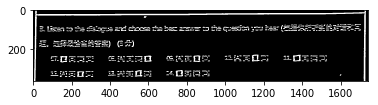

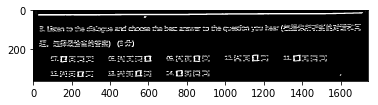

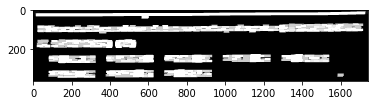

y mean --> 257.625
y std --> 37.81843961614493
[[232, 79, 45, 250], [230, 378, 44, 253], [229, 680, 46, 255], [225, 984, 47, 255], [226, 1289, 46, 255], [310, 78, 42, 250], [305, 376, 45, 254], [304, 679, 45, 254]]
{14: [304, 679, 45, 254], 13: [305, 376, 45, 254], 12: [310, 78, 42, 250], 11: [226, 1289, 46, 255], 10: [225, 984, 47, 255], 9: [229, 680, 46, 255], 8: [230, 378, 44, 253], 7: [232, 79, 45, 250]}


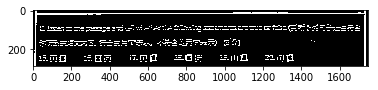

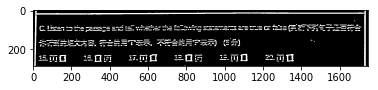

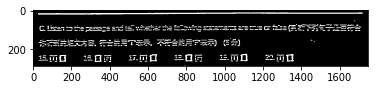

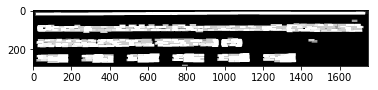

y mean --> 222.66666666666666
y std --> 2.1343747458109497
[[226, 15, 48, 172], [225, 250, 49, 172], [222, 486, 51, 176], [222, 723, 50, 173], [220, 959, 51, 175], [221, 1198, 51, 177]]
{20: [221, 1198, 51, 177], 19: [220, 959, 51, 175], 18: [222, 723, 50, 173], 17: [222, 486, 51, 176], 16: [225, 250, 49, 172], 15: [226, 15, 48, 172]}


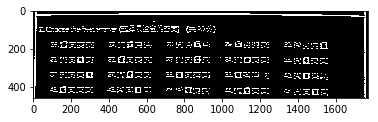

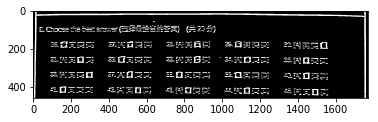

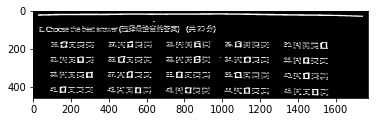

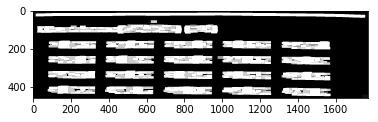

y mean --> 265.2857142857143
y std --> 98.55003218435503
[[70, 797, 51, 182], [154, 80, 47, 256], [153, 384, 47, 258], [153, 691, 46, 260], [153, 1000, 47, 260], [157, 1311, 48, 262], [234, 78, 46, 256], [232, 382, 47, 259], [232, 689, 48, 261], [235, 973, 46, 287], [238, 1311, 47, 261], [315, 77, 44, 254], [312, 381, 48, 259], [314, 689, 47, 260], [316, 998, 47, 263], [319, 1311, 49, 262], [392, 75, 47, 256], [396, 379, 45, 258], [396, 687, 46, 261], [397, 997, 48, 264], [403, 1312, 49, 262]]
{45: [403, 1312, 49, 262], 44: [397, 997, 48, 264], 43: [396, 687, 46, 261], 42: [396, 379, 45, 258], 41: [392, 75, 47, 256], 40: [319, 1311, 49, 262], 39: [316, 998, 47, 263], 38: [314, 689, 47, 260], 37: [312, 381, 48, 259], 36: [315, 77, 44, 254], 35: [238, 1311, 47, 261], 34: [235, 973, 46, 287], 33: [232, 689, 48, 261], 32: [232, 382, 47, 259], 31: [234, 78, 46, 256], 30: [157, 1311, 48, 262], 29: [153, 1000, 47, 260], 28: [153, 691, 46, 260], 27: [153, 384, 47, 258], 26: [154, 80, 47, 256]}

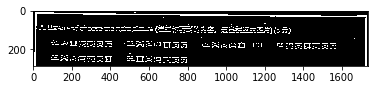

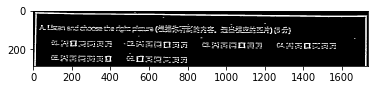

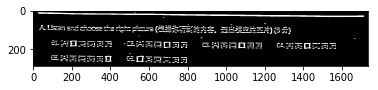

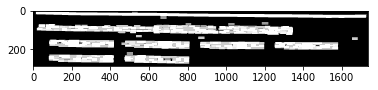

y mean --> 175.0
y std --> 31.203632267200348
[[146, 81, 46, 340], [151, 456, 47, 358], [157, 863, 43, 337], [159, 1249, 43, 334], [224, 80, 45, 341], [213, 471, 62, 341]]
{6: [213, 471, 62, 341], 5: [224, 80, 45, 341], 4: [159, 1249, 43, 334], 3: [157, 863, 43, 337], 2: [151, 456, 47, 358], 1: [146, 81, 46, 340]}


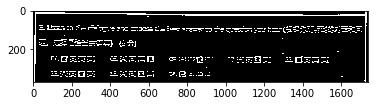

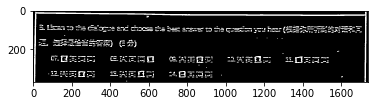

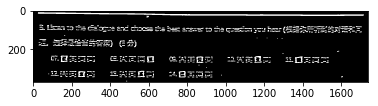

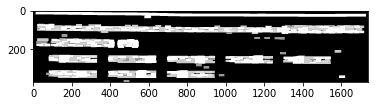

y mean --> 259.125
y std --> 36.84575111189891
[[228, 79, 45, 257], [231, 388, 44, 256], [232, 694, 58, 254], [230, 997, 47, 252], [232, 1297, 46, 253], [307, 65, 43, 270], [306, 386, 45, 257], [307, 693, 44, 253]]
{14: [307, 693, 44, 253], 13: [306, 386, 45, 257], 12: [307, 65, 43, 270], 11: [232, 1297, 46, 253], 10: [230, 997, 47, 252], 9: [232, 694, 58, 254], 8: [231, 388, 44, 256], 7: [228, 79, 45, 257]}


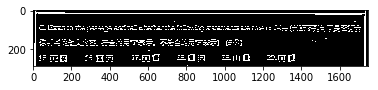

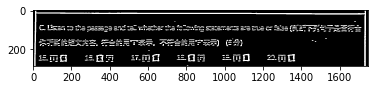

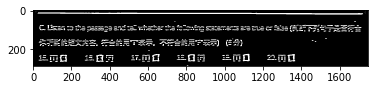

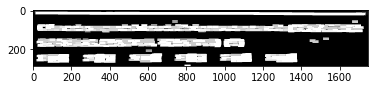

y mean --> 222.16666666666666
y std --> 1.7716909687891083
[[225, 15, 49, 176], [224, 256, 50, 178], [221, 497, 51, 179], [222, 736, 50, 174], [220, 973, 51, 172], [221, 1208, 51, 174]]
{20: [221, 1208, 51, 174], 19: [220, 973, 51, 172], 18: [222, 736, 50, 174], 17: [221, 497, 51, 179], 16: [224, 256, 50, 178], 15: [225, 15, 49, 176]}


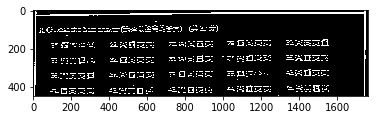

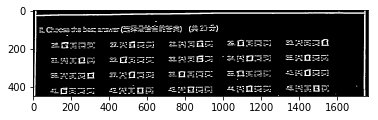

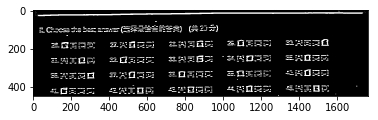

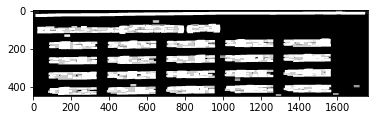

y mean --> 262.9047619047619
y std --> 96.54059336776656
[[70, 806, 53, 182], [161, 82, 46, 259], [157, 391, 49, 260], [154, 701, 47, 259], [150, 1008, 46, 258], [146, 1315, 48, 255], [241, 81, 45, 258], [237, 389, 47, 261], [231, 699, 49, 260], [231, 981, 44, 285], [227, 1315, 46, 253], [320, 79, 45, 258], [316, 388, 47, 261], [313, 699, 45, 260], [310, 1006, 44, 260], [304, 1315, 47, 254], [399, 77, 47, 260], [385, 386, 59, 261], [394, 697, 45, 261], [388, 1007, 48, 259], [387, 1316, 46, 256]]
{45: [387, 1316, 46, 256], 44: [388, 1007, 48, 259], 43: [394, 697, 45, 261], 42: [385, 386, 59, 261], 41: [399, 77, 47, 260], 40: [304, 1315, 47, 254], 39: [310, 1006, 44, 260], 38: [313, 699, 45, 260], 37: [316, 388, 47, 261], 36: [320, 79, 45, 258], 35: [227, 1315, 46, 253], 34: [231, 981, 44, 285], 33: [231, 699, 49, 260], 32: [237, 389, 47, 261], 31: [241, 81, 45, 258], 30: [146, 1315, 48, 255], 29: [150, 1008, 46, 258], 28: [154, 701, 47, 259], 27: [157, 391, 49, 260], 26: [161, 82, 46, 2

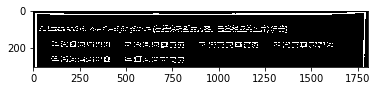

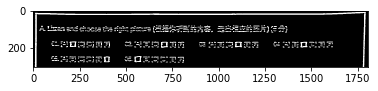

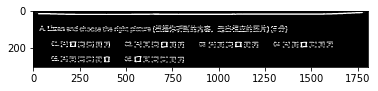

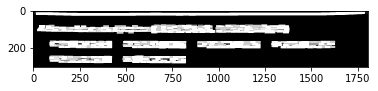

y mean --> 187.83333333333334
y std --> 36.539552390374034
[[161, 86, 44, 343], [162, 481, 45, 348], [163, 881, 43, 348], [162, 1282, 44, 348], [240, 85, 45, 344], [239, 480, 47, 347]]
{6: [239, 480, 47, 347], 5: [240, 85, 45, 344], 4: [162, 1282, 44, 348], 3: [163, 881, 43, 348], 2: [162, 481, 45, 348], 1: [161, 86, 44, 343]}


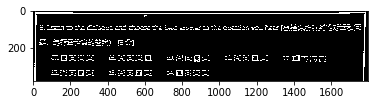

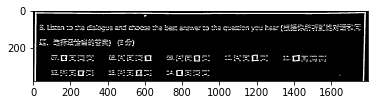

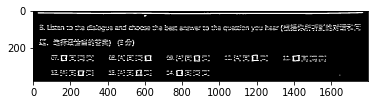

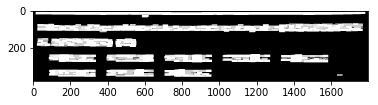

y mean --> 262.625
y std --> 38.265315561223325
[[233, 83, 45, 257], [234, 392, 44, 259], [234, 703, 46, 259], [231, 1015, 48, 260], [233, 1327, 47, 260], [314, 84, 43, 255], [311, 391, 45, 259], [311, 703, 46, 257]]
{14: [311, 703, 46, 257], 13: [311, 391, 45, 259], 12: [314, 84, 43, 255], 11: [233, 1327, 47, 260], 10: [231, 1015, 48, 260], 9: [234, 703, 46, 259], 8: [234, 392, 44, 259], 7: [233, 83, 45, 257]}


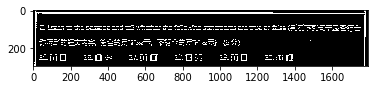

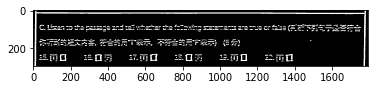

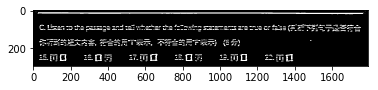

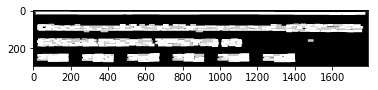

y mean --> 226.66666666666666
y std --> 1.1055415967851334
[[228, 18, 49, 175], [228, 259, 50, 176], [225, 500, 52, 180], [226, 744, 51, 174], [226, 984, 51, 176], [227, 1227, 51, 179]]
{20: [227, 1227, 51, 179], 19: [226, 984, 51, 176], 18: [226, 744, 51, 174], 17: [225, 500, 52, 180], 16: [228, 259, 50, 176], 15: [228, 18, 49, 175]}


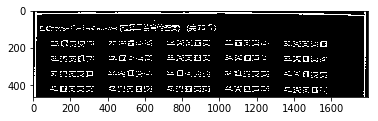

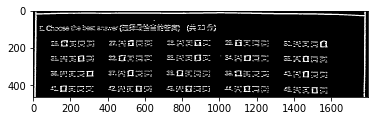

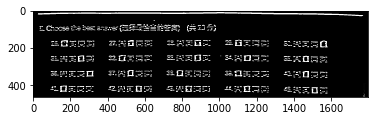

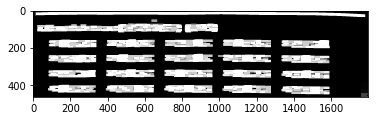

y mean --> 265.7142857142857
y std --> 98.91802419278339
[[70, 812, 51, 183], [155, 83, 47, 260], [153, 393, 47, 262], [153, 706, 46, 260], [152, 1017, 48, 262], [157, 1331, 48, 263], [236, 81, 46, 260], [233, 391, 47, 262], [231, 704, 48, 262], [235, 991, 45, 288], [238, 1331, 47, 261], [317, 81, 44, 258], [313, 390, 47, 263], [314, 703, 46, 262], [315, 1015, 47, 264], [318, 1331, 49, 262], [396, 79, 46, 260], [397, 388, 45, 263], [397, 701, 46, 263], [397, 1014, 48, 264], [403, 1331, 48, 263]]
{45: [403, 1331, 48, 263], 44: [397, 1014, 48, 264], 43: [397, 701, 46, 263], 42: [397, 388, 45, 263], 41: [396, 79, 46, 260], 40: [318, 1331, 49, 262], 39: [315, 1015, 47, 264], 38: [314, 703, 46, 262], 37: [313, 390, 47, 263], 36: [317, 81, 44, 258], 35: [238, 1331, 47, 261], 34: [235, 991, 45, 288], 33: [231, 704, 48, 262], 32: [233, 391, 47, 262], 31: [236, 81, 46, 260], 30: [157, 1331, 48, 263], 29: [152, 1017, 48, 262], 28: [153, 706, 46, 260], 27: [153, 393, 47, 262], 26: [155, 83, 47, 2

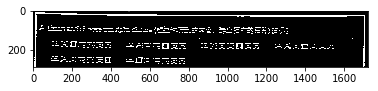

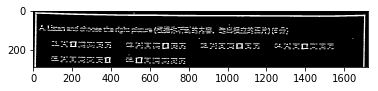

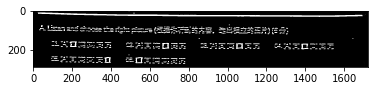

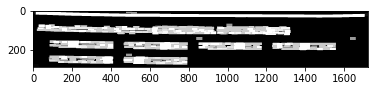

y mean --> 180.83333333333334
y std --> 31.184486884061798
[[152, 82, 47, 334], [159, 464, 45, 335], [162, 848, 42, 331], [163, 1227, 43, 333], [229, 79, 46, 336], [220, 463, 59, 334]]
{6: [220, 463, 59, 334], 5: [229, 79, 46, 336], 4: [163, 1227, 43, 333], 3: [162, 848, 42, 331], 2: [159, 464, 45, 335], 1: [152, 82, 47, 334]}


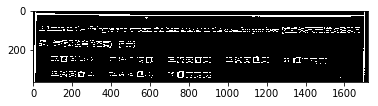

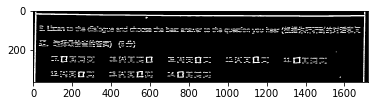

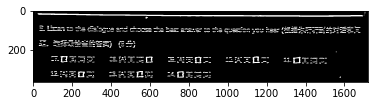

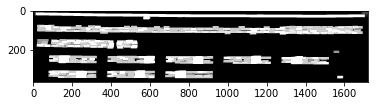

y mean --> 255.75
y std --> 36.36189626518397
[[225, 80, 45, 251], [228, 380, 44, 249], [229, 680, 45, 248], [227, 975, 47, 251], [229, 1273, 47, 250], [303, 77, 43, 251], [302, 377, 45, 252], [303, 676, 44, 251]]
{14: [303, 676, 44, 251], 13: [302, 377, 45, 252], 12: [303, 77, 43, 251], 11: [229, 1273, 47, 250], 10: [227, 975, 47, 251], 9: [229, 680, 45, 248], 8: [228, 380, 44, 249], 7: [225, 80, 45, 251]}


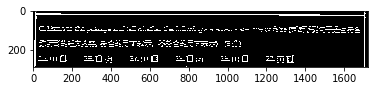

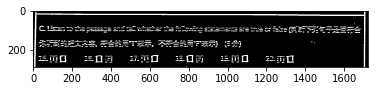

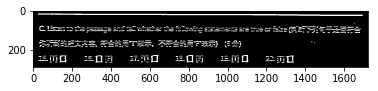

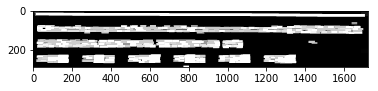

y mean --> 221.0
y std --> 1.0
[[222, 14, 48, 173], [222, 249, 49, 173], [220, 485, 50, 174], [220, 719, 50, 170], [220, 950, 50, 171], [222, 1183, 50, 173]]
{20: [222, 1183, 50, 173], 19: [220, 950, 50, 171], 18: [220, 719, 50, 170], 17: [220, 485, 50, 174], 16: [222, 249, 49, 173], 15: [222, 14, 48, 173]}


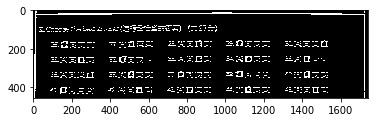

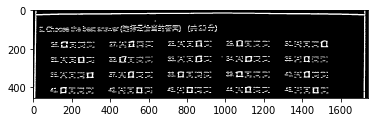

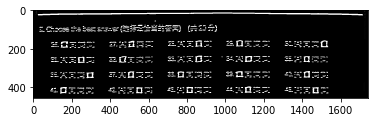

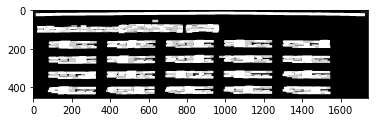

y mean --> 263.0
y std --> 97.09739832716818
[[70, 791, 50, 179], [157, 79, 46, 255], [154, 383, 47, 256], [152, 688, 46, 254], [151, 991, 46, 254], [152, 1295, 47, 253], [236, 78, 45, 254], [233, 381, 46, 256], [230, 686, 47, 255], [232, 965, 44, 280], [233, 1294, 44, 253], [316, 77, 44, 253], [312, 380, 46, 257], [312, 685, 45, 256], [311, 989, 45, 257], [310, 1294, 47, 254], [393, 75, 46, 254], [394, 377, 45, 257], [392, 684, 45, 256], [390, 989, 47, 256], [393, 1294, 45, 255]]
{45: [393, 1294, 45, 255], 44: [390, 989, 47, 256], 43: [392, 684, 45, 256], 42: [394, 377, 45, 257], 41: [393, 75, 46, 254], 40: [310, 1294, 47, 254], 39: [311, 989, 45, 257], 38: [312, 685, 45, 256], 37: [312, 380, 46, 257], 36: [316, 77, 44, 253], 35: [233, 1294, 44, 253], 34: [232, 965, 44, 280], 33: [230, 686, 47, 255], 32: [233, 381, 46, 256], 31: [236, 78, 45, 254], 30: [152, 1295, 47, 253], 29: [151, 991, 46, 254], 28: [152, 688, 46, 254], 27: [154, 383, 47, 256], 26: [157, 79, 46, 255]}
------------ 

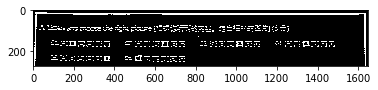

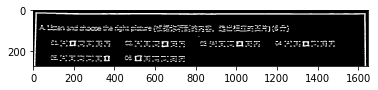

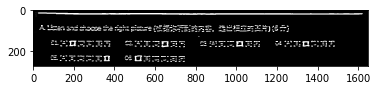

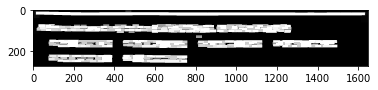

y mean --> 167.5
y std --> 33.59935515254224
[[142, 75, 42, 320], [144, 440, 43, 322], [145, 808, 41, 323], [144, 1177, 40, 322], [215, 73, 42, 320], [215, 438, 44, 324]]
{6: [215, 438, 44, 324], 5: [215, 73, 42, 320], 4: [144, 1177, 40, 322], 3: [145, 808, 41, 323], 2: [144, 440, 43, 322], 1: [142, 75, 42, 320]}


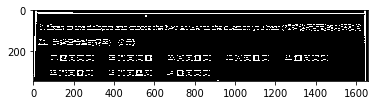

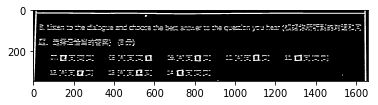

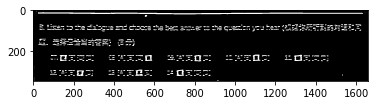

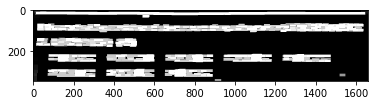

y mean --> 230.0
y std --> 47.40370355901648
[[135, 13, 49, 387], [215, 73, 42, 242], [215, 361, 42, 243], [215, 652, 44, 242], [213, 940, 44, 244], [214, 1232, 44, 244], [289, 70, 42, 242], [287, 360, 43, 243], [287, 650, 43, 242]]
{14: [287, 650, 43, 242], 13: [287, 360, 43, 243], 12: [289, 70, 42, 242], 11: [214, 1232, 44, 244], 10: [213, 940, 44, 244], 9: [215, 652, 44, 242], 8: [215, 361, 42, 243], 7: [215, 73, 42, 242]}


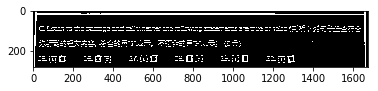

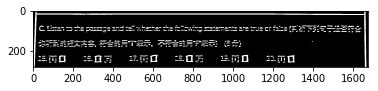

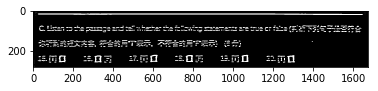

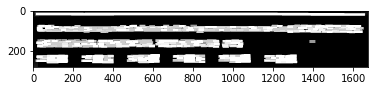

y mean --> 211.16666666666666
y std --> 4.6696419087073
[[201, 0, 78, 178], [215, 239, 48, 168], [212, 467, 50, 170], [213, 696, 48, 167], [212, 924, 49, 167], [214, 1152, 49, 171]]
{20: [214, 1152, 49, 171], 19: [212, 924, 49, 167], 18: [213, 696, 48, 167], 17: [212, 467, 50, 170], 16: [215, 239, 48, 168], 15: [201, 0, 78, 178]}


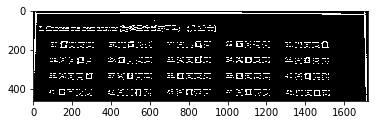

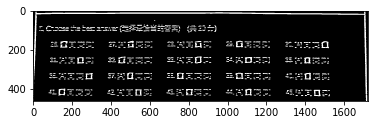

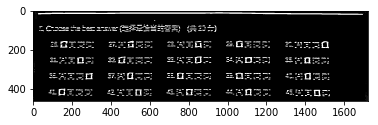

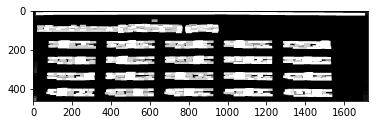

y mean --> 263.7142857142857
y std --> 98.82507049237621
[[70, 779, 50, 178], [152, 76, 46, 252], [151, 376, 48, 252], [152, 677, 46, 253], [151, 978, 46, 254], [153, 1283, 47, 253], [234, 73, 45, 252], [231, 372, 48, 255], [230, 675, 48, 255], [233, 978, 44, 254], [234, 1282, 45, 253], [315, 69, 45, 252], [312, 370, 48, 256], [313, 674, 45, 255], [313, 978, 47, 256], [313, 1283, 48, 255], [394, 66, 48, 253], [397, 367, 46, 257], [396, 672, 46, 257], [395, 977, 47, 258], [399, 1285, 46, 256]]
{45: [399, 1285, 46, 256], 44: [395, 977, 47, 258], 43: [396, 672, 46, 257], 42: [397, 367, 46, 257], 41: [394, 66, 48, 253], 40: [313, 1283, 48, 255], 39: [313, 978, 47, 256], 38: [313, 674, 45, 255], 37: [312, 370, 48, 256], 36: [315, 69, 45, 252], 35: [234, 1282, 45, 253], 34: [233, 978, 44, 254], 33: [230, 675, 48, 255], 32: [231, 372, 48, 255], 31: [234, 73, 45, 252], 30: [153, 1283, 47, 253], 29: [151, 978, 46, 254], 28: [152, 677, 46, 253], 27: [151, 376, 48, 252], 26: [152, 76, 46, 252]}
-

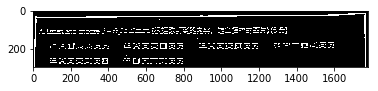

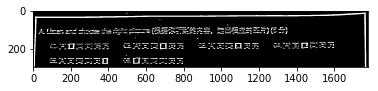

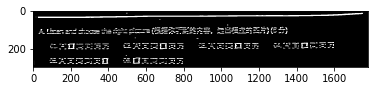

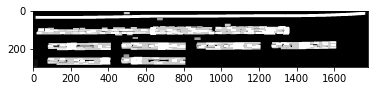

y mean --> 186.66666666666666
y std --> 34.48510145297854
[[165, 77, 44, 339], [164, 467, 44, 346], [163, 865, 44, 346], [158, 1264, 46, 349], [242, 74, 44, 340], [228, 465, 57, 347]]
{6: [228, 465, 57, 347], 5: [242, 74, 44, 340], 4: [158, 1264, 46, 349], 3: [163, 865, 44, 346], 2: [164, 467, 44, 346], 1: [165, 77, 44, 339]}


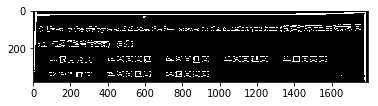

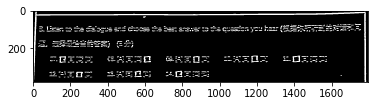

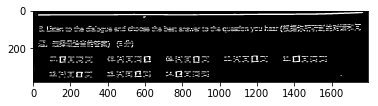

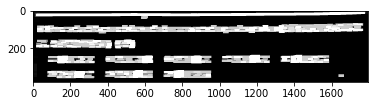

y mean --> 267.125
y std --> 38.93082808007043
[[239, 77, 46, 256], [238, 386, 46, 260], [238, 699, 47, 259], [235, 1010, 48, 262], [235, 1325, 47, 264], [320, 74, 43, 257], [316, 383, 46, 262], [316, 697, 46, 260]]
{14: [316, 697, 46, 260], 13: [316, 383, 46, 262], 12: [320, 74, 43, 257], 11: [235, 1325, 47, 264], 10: [235, 1010, 48, 262], 9: [238, 699, 47, 259], 8: [238, 386, 46, 260], 7: [239, 77, 46, 256]}


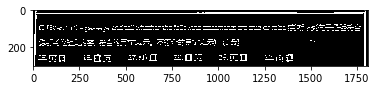

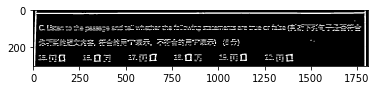

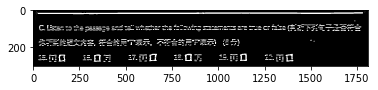

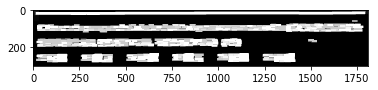

y mean --> 230.0
y std --> 1.8257418583505538
[[233, 14, 50, 175], [232, 255, 51, 179], [229, 501, 52, 182], [229, 748, 51, 176], [228, 991, 52, 179], [229, 1238, 53, 182]]
{20: [229, 1238, 53, 182], 19: [228, 991, 52, 179], 18: [229, 748, 51, 176], 17: [229, 501, 52, 182], 16: [232, 255, 51, 179], 15: [233, 14, 50, 175]}


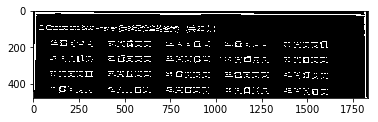

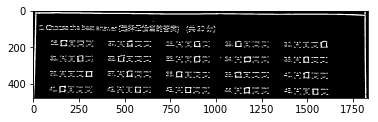

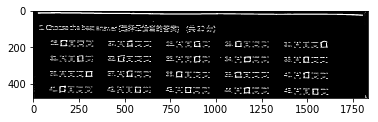

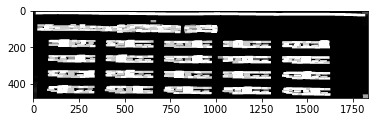

y mean --> 275.0
y std --> 101.3598023074706
[[78, 824, 50, 188], [156, 83, 48, 261], [159, 396, 48, 265], [162, 715, 46, 267], [161, 1037, 48, 267], [161, 1360, 50, 266], [240, 80, 47, 263], [239, 395, 49, 265], [242, 714, 49, 267], [246, 1008, 45, 296], [247, 1359, 46, 266], [324, 79, 46, 261], [322, 394, 49, 266], [326, 714, 48, 267], [329, 1035, 46, 269], [329, 1359, 50, 268], [405, 75, 49, 264], [409, 391, 46, 268], [411, 712, 48, 268], [412, 1034, 48, 270], [417, 1360, 50, 269]]
{45: [417, 1360, 50, 269], 44: [412, 1034, 48, 270], 43: [411, 712, 48, 268], 42: [409, 391, 46, 268], 41: [405, 75, 49, 264], 40: [329, 1359, 50, 268], 39: [329, 1035, 46, 269], 38: [326, 714, 48, 267], 37: [322, 394, 49, 266], 36: [324, 79, 46, 261], 35: [247, 1359, 46, 266], 34: [246, 1008, 45, 296], 33: [242, 714, 49, 267], 32: [239, 395, 49, 265], 31: [240, 80, 47, 263], 30: [161, 1360, 50, 266], 29: [161, 1037, 48, 267], 28: [162, 715, 46, 267], 27: [159, 396, 48, 265], 26: [156, 83, 48, 261]}
-----

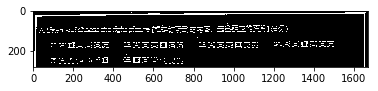

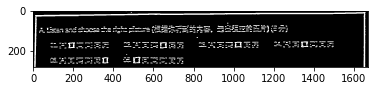

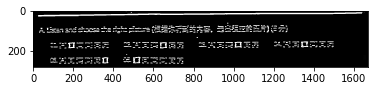

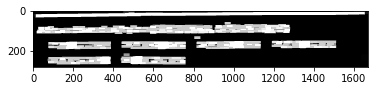

y mean --> 173.5
y std --> 32.46408271716093
[[153, 74, 42, 317], [152, 439, 43, 326], [150, 813, 43, 325], [148, 1187, 42, 326], [226, 71, 43, 319], [212, 436, 57, 328]]
{6: [212, 436, 57, 328], 5: [226, 71, 43, 319], 4: [148, 1187, 42, 326], 3: [150, 813, 43, 325], 2: [152, 439, 43, 326], 1: [153, 74, 42, 317]}


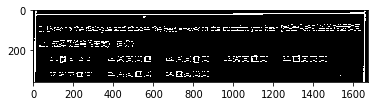

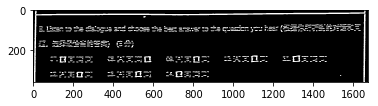

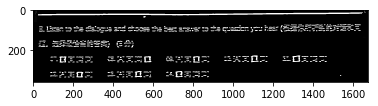

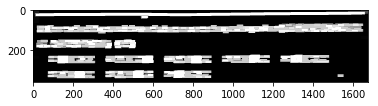

y mean --> 239.11111111111111
y std --> 47.90371000349311
[[145, 14, 48, 383], [225, 73, 43, 240], [224, 359, 43, 246], [224, 651, 44, 243], [220, 941, 46, 245], [220, 1233, 45, 248], [300, 71, 41, 240], [297, 358, 44, 246], [297, 650, 43, 243]]
{14: [297, 650, 43, 243], 13: [297, 358, 44, 246], 12: [300, 71, 41, 240], 11: [220, 1233, 45, 248], 10: [220, 941, 46, 245], 9: [224, 651, 44, 243], 8: [224, 359, 43, 246], 7: [225, 73, 43, 240]}


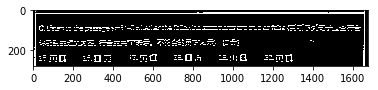

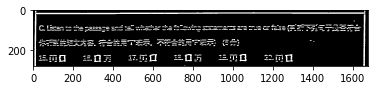

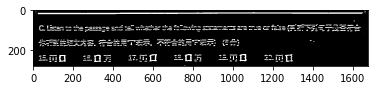

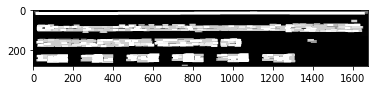

y mean --> 213.83333333333334
y std --> 1.950783318453271
[[217, 0, 61, 178], [216, 236, 48, 168], [213, 463, 49, 171], [212, 691, 49, 166], [212, 915, 49, 169], [213, 1144, 50, 171]]
{20: [213, 1144, 50, 171], 19: [212, 915, 49, 169], 18: [212, 691, 49, 166], 17: [213, 463, 49, 171], 16: [216, 236, 48, 168], 15: [217, 0, 61, 178]}


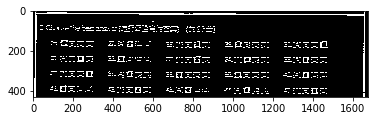

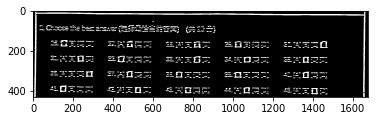

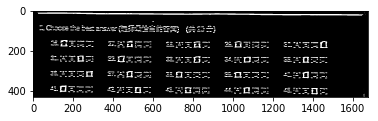

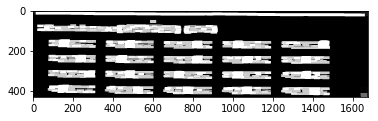

y mean --> 251.8095238095238
y std --> 91.84283628004809
[[72, 751, 48, 175], [143, 75, 46, 242], [147, 361, 44, 245], [150, 651, 43, 248], [149, 945, 44, 248], [148, 1239, 46, 248], [220, 74, 43, 242], [221, 360, 45, 246], [223, 651, 45, 248], [226, 944, 42, 248], [226, 1239, 43, 246], [295, 73, 43, 241], [296, 359, 46, 246], [299, 650, 45, 248], [301, 943, 43, 250], [299, 1238, 46, 247], [368, 72, 46, 242], [374, 357, 44, 247], [376, 649, 43, 248], [376, 942, 44, 250], [379, 1238, 45, 249]]
{45: [379, 1238, 45, 249], 44: [376, 942, 44, 250], 43: [376, 649, 43, 248], 42: [374, 357, 44, 247], 41: [368, 72, 46, 242], 40: [299, 1238, 46, 247], 39: [301, 943, 43, 250], 38: [299, 650, 45, 248], 37: [296, 359, 46, 246], 36: [295, 73, 43, 241], 35: [226, 1239, 43, 246], 34: [226, 944, 42, 248], 33: [223, 651, 45, 248], 32: [221, 360, 45, 246], 31: [220, 74, 43, 242], 30: [148, 1239, 46, 248], 29: [149, 945, 44, 248], 28: [150, 651, 43, 248], 27: [147, 361, 44, 245], 26: [143, 75, 46, 242]}
-

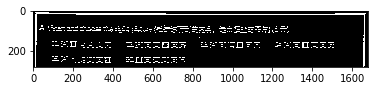

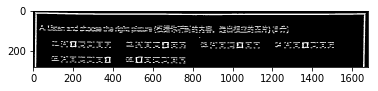

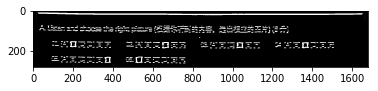

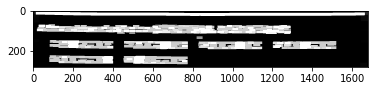

y mean --> 174.83333333333334
y std --> 34.11459446564704
[[147, 81, 45, 324], [151, 454, 44, 325], [153, 826, 42, 325], [152, 1200, 42, 323], [222, 78, 44, 326], [224, 451, 45, 327]]
{6: [224, 451, 45, 327], 5: [222, 78, 44, 326], 4: [152, 1200, 42, 323], 3: [153, 826, 42, 325], 2: [151, 454, 44, 325], 1: [147, 81, 45, 324]}


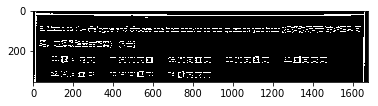

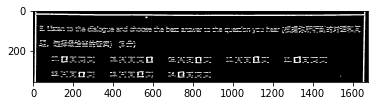

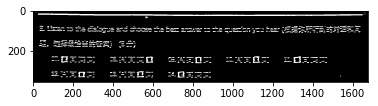

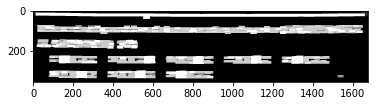

y mean --> 249.125
y std --> 36.06396227537956
[[220, 79, 44, 244], [222, 372, 43, 243], [223, 662, 44, 244], [220, 952, 46, 243], [221, 1242, 45, 244], [296, 77, 42, 245], [295, 370, 43, 245], [296, 661, 43, 244]]
{14: [296, 661, 43, 244], 13: [295, 370, 43, 245], 12: [296, 77, 42, 245], 11: [221, 1242, 45, 244], 10: [220, 952, 46, 243], 9: [223, 662, 44, 244], 8: [222, 372, 43, 243], 7: [220, 79, 44, 244]}


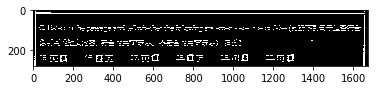

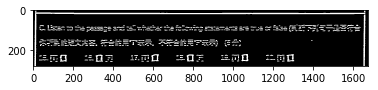

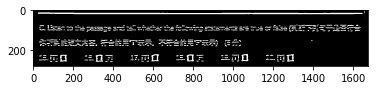

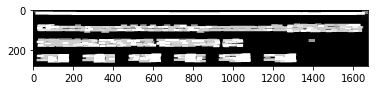

y mean --> 213.83333333333334
y std --> 1.343709624716425
[[216, 16, 47, 167], [215, 244, 48, 168], [213, 472, 49, 171], [214, 701, 48, 165], [212, 925, 49, 165], [213, 1150, 49, 168]]
{20: [213, 1150, 49, 168], 19: [212, 925, 49, 165], 18: [214, 701, 48, 165], 17: [213, 472, 49, 171], 16: [215, 244, 48, 168], 15: [216, 16, 47, 167]}


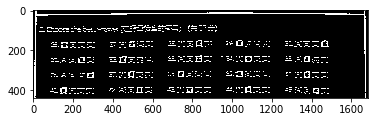

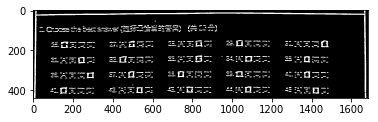

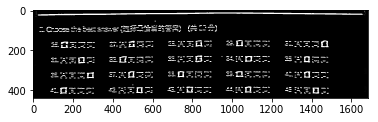

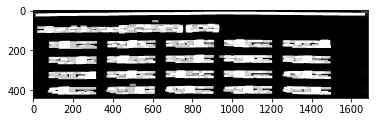

y mean --> 252.14285714285714
y std --> 92.69678461279561
[[67, 765, 48, 173], [152, 77, 44, 247], [148, 371, 46, 247], [145, 665, 45, 247], [144, 958, 45, 246], [146, 1251, 46, 248], [228, 76, 44, 246], [224, 369, 45, 249], [220, 664, 46, 247], [223, 933, 42, 271], [224, 1251, 44, 246], [304, 75, 43, 245], [299, 367, 46, 250], [298, 664, 44, 246], [299, 956, 43, 249], [300, 1251, 46, 247], [379, 72, 45, 248], [366, 366, 56, 248], [376, 661, 44, 248], [375, 955, 45, 249], [378, 1252, 46, 248]]
{45: [378, 1252, 46, 248], 44: [375, 955, 45, 249], 43: [376, 661, 44, 248], 42: [366, 366, 56, 248], 41: [379, 72, 45, 248], 40: [300, 1251, 46, 247], 39: [299, 956, 43, 249], 38: [298, 664, 44, 246], 37: [299, 367, 46, 250], 36: [304, 75, 43, 245], 35: [224, 1251, 44, 246], 34: [223, 933, 42, 271], 33: [220, 664, 46, 247], 32: [224, 369, 45, 249], 31: [228, 76, 44, 246], 30: [146, 1251, 46, 248], 29: [144, 958, 45, 246], 28: [145, 665, 45, 247], 27: [148, 371, 46, 247], 26: [152, 77, 44, 247]}


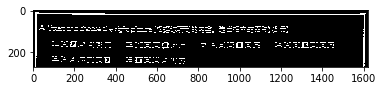

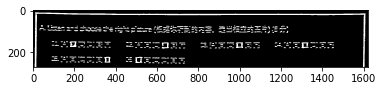

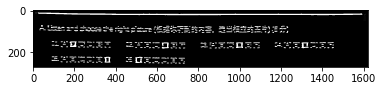

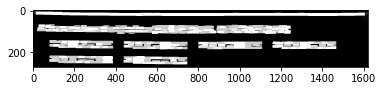

y mean --> 170.16666666666666
y std --> 33.17336615754003
[[143, 77, 43, 313], [147, 436, 44, 314], [149, 797, 41, 314], [148, 1156, 41, 314], [216, 76, 42, 313], [218, 435, 45, 314]]
{6: [218, 435, 45, 314], 5: [216, 76, 42, 313], 4: [148, 1156, 41, 314], 3: [149, 797, 41, 314], 2: [147, 436, 44, 314], 1: [143, 77, 43, 313]}


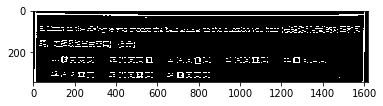

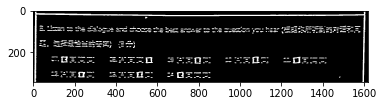

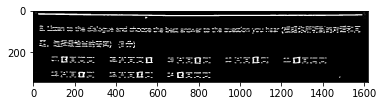

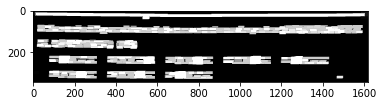

y mean --> 230.11111111111111
y std --> 47.03295403684632
[[135, 16, 49, 377], [213, 75, 43, 236], [216, 357, 42, 236], [217, 637, 44, 236], [214, 916, 45, 236], [215, 1196, 44, 237], [286, 74, 42, 236], [287, 355, 42, 237], [288, 635, 42, 236]]
{14: [288, 635, 42, 236], 13: [287, 355, 42, 237], 12: [286, 74, 42, 236], 11: [215, 1196, 44, 237], 10: [214, 916, 45, 236], 9: [217, 637, 44, 236], 8: [216, 357, 42, 236], 7: [213, 75, 43, 236]}


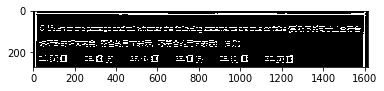

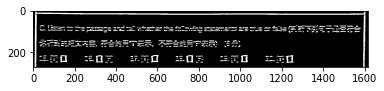

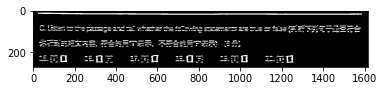

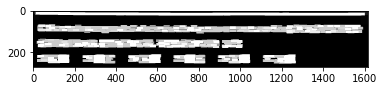

y mean --> 208.66666666666666
y std --> 0.4714045207910317
[[209, 17, 46, 161], [209, 236, 47, 163], [208, 456, 47, 164], [209, 674, 47, 160], [208, 890, 48, 160], [209, 1107, 48, 164]]
{20: [209, 1107, 48, 164], 19: [208, 890, 48, 160], 18: [209, 674, 47, 160], 17: [208, 456, 47, 164], 16: [209, 236, 47, 163], 15: [209, 17, 46, 161]}


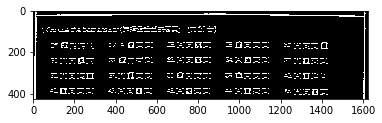

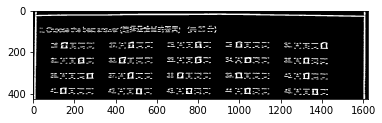

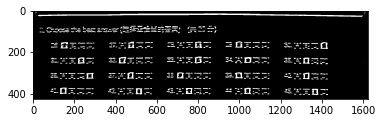

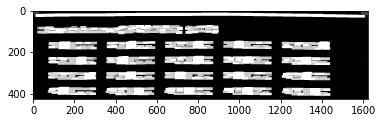

y mean --> 245.76190476190476
y std --> 90.85252558897683
[[66, 735, 46, 168], [145, 73, 43, 239], [142, 355, 45, 240], [142, 638, 44, 239], [141, 920, 45, 240], [145, 1203, 45, 240], [219, 72, 43, 238], [216, 353, 45, 241], [215, 636, 45, 241], [217, 920, 43, 239], [220, 1203, 43, 240], [293, 71, 42, 237], [290, 352, 45, 241], [291, 635, 43, 241], [291, 919, 44, 241], [292, 1204, 45, 239], [365, 70, 44, 238], [368, 350, 42, 241], [367, 634, 42, 240], [366, 918, 44, 242], [370, 1204, 43, 240]]
{45: [370, 1204, 43, 240], 44: [366, 918, 44, 242], 43: [367, 634, 42, 240], 42: [368, 350, 42, 241], 41: [365, 70, 44, 238], 40: [292, 1204, 45, 239], 39: [291, 919, 44, 241], 38: [291, 635, 43, 241], 37: [290, 352, 45, 241], 36: [293, 71, 42, 237], 35: [220, 1203, 43, 240], 34: [217, 920, 43, 239], 33: [215, 636, 45, 241], 32: [216, 353, 45, 241], 31: [219, 72, 43, 238], 30: [145, 1203, 45, 240], 29: [141, 920, 45, 240], 28: [142, 638, 44, 239], 27: [142, 355, 45, 240], 26: [145, 73, 43, 239]}


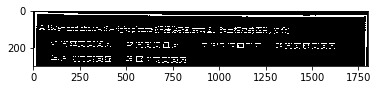

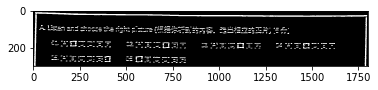

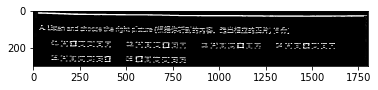

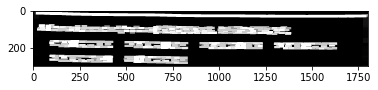

y mean --> 185.0
y std --> 34.90940656422946
[[153, 85, 48, 349], [159, 489, 48, 348], [164, 892, 43, 346], [166, 1292, 43, 346], [232, 85, 47, 348], [236, 485, 49, 350]]
{6: [236, 485, 49, 350], 5: [232, 85, 47, 348], 4: [166, 1292, 43, 346], 3: [164, 892, 43, 346], 2: [159, 489, 48, 348], 1: [153, 85, 48, 349]}


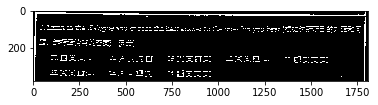

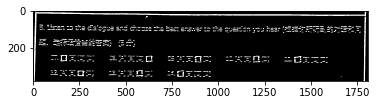

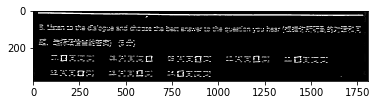

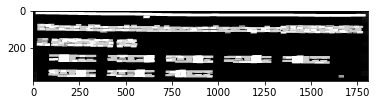

y mean --> 266.75
y std --> 37.6687868134879
[[234, 84, 46, 260], [237, 398, 46, 261], [239, 713, 47, 262], [238, 1027, 48, 262], [240, 1342, 48, 262], [315, 80, 45, 262], [315, 395, 46, 263], [316, 711, 47, 261]]
{14: [316, 711, 47, 261], 13: [315, 395, 46, 263], 12: [315, 80, 45, 262], 11: [240, 1342, 48, 262], 10: [238, 1027, 48, 262], 9: [239, 713, 47, 262], 8: [237, 398, 46, 261], 7: [234, 84, 46, 260]}


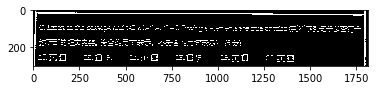

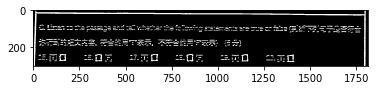

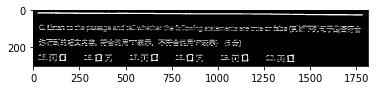

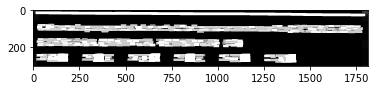

y mean --> 231.5
y std --> 1.2583057392117916
[[231, 0, 70, 194], [231, 262, 51, 179], [230, 509, 52, 183], [231, 758, 52, 176], [232, 1002, 51, 178], [234, 1248, 52, 181]]
{20: [234, 1248, 52, 181], 19: [232, 1002, 51, 178], 18: [231, 758, 52, 176], 17: [230, 509, 52, 183], 16: [231, 262, 51, 179], 15: [231, 0, 70, 194]}


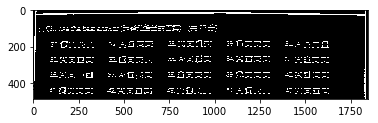

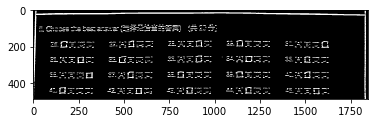

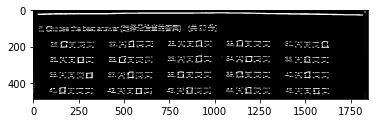

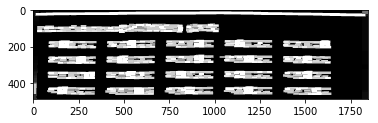

y mean --> 279.6190476190476
y std --> 104.08443284659685
[[73, 841, 53, 187], [165, 83, 48, 269], [162, 406, 50, 270], [161, 730, 48, 268], [159, 1052, 49, 268], [164, 1375, 49, 269], [250, 80, 48, 269], [247, 402, 49, 272], [243, 727, 51, 270], [246, 1026, 46, 294], [248, 1375, 48, 267], [336, 78, 45, 266], [332, 400, 50, 272], [331, 726, 48, 270], [331, 1050, 48, 271], [331, 1375, 50, 268], [417, 75, 50, 268], [421, 396, 46, 273], [418, 723, 48, 272], [416, 1049, 49, 272], [421, 1377, 47, 268]]
{45: [421, 1377, 47, 268], 44: [416, 1049, 49, 272], 43: [418, 723, 48, 272], 42: [421, 396, 46, 273], 41: [417, 75, 50, 268], 40: [331, 1375, 50, 268], 39: [331, 1050, 48, 271], 38: [331, 726, 48, 270], 37: [332, 400, 50, 272], 36: [336, 78, 45, 266], 35: [248, 1375, 48, 267], 34: [246, 1026, 46, 294], 33: [243, 727, 51, 270], 32: [247, 402, 49, 272], 31: [250, 80, 48, 269], 30: [164, 1375, 49, 269], 29: [159, 1052, 49, 268], 28: [161, 730, 48, 268], 27: [162, 406, 50, 270], 26: [165, 83, 48

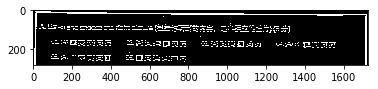

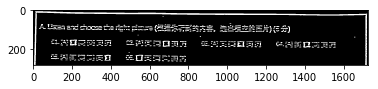

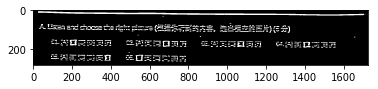

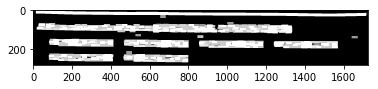

y mean --> 172.33333333333334
y std --> 30.874297113006836
[[145, 80, 44, 337], [149, 466, 45, 338], [153, 853, 43, 336], [156, 1238, 42, 334], [221, 79, 44, 337], [210, 464, 60, 338]]
{6: [210, 464, 60, 338], 5: [221, 79, 44, 337], 4: [156, 1238, 42, 334], 3: [153, 853, 43, 336], 2: [149, 466, 45, 338], 1: [145, 80, 44, 337]}


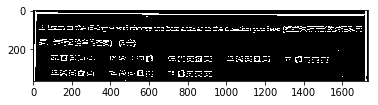

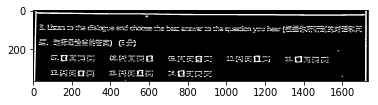

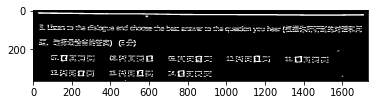

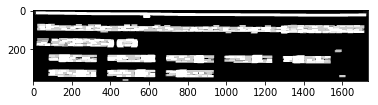

y mean --> 255.875
y std --> 36.27132993150375
[[225, 79, 45, 254], [227, 383, 44, 253], [229, 686, 46, 253], [228, 987, 47, 253], [230, 1289, 46, 253], [303, 77, 43, 253], [302, 381, 45, 254], [303, 684, 45, 253]]
{14: [303, 684, 45, 253], 13: [302, 381, 45, 254], 12: [303, 77, 43, 253], 11: [230, 1289, 46, 253], 10: [228, 987, 47, 253], 9: [229, 686, 46, 253], 8: [227, 383, 44, 253], 7: [225, 79, 45, 254]}


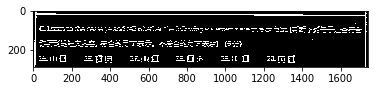

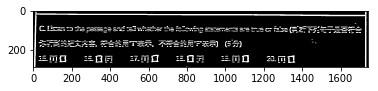

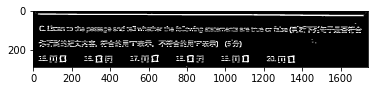

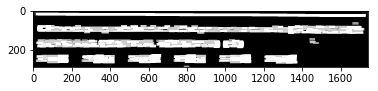

y mean --> 222.66666666666666
y std --> 1.1055415967851334
[[224, 15, 48, 173], [223, 251, 50, 176], [221, 491, 51, 177], [222, 729, 50, 173], [222, 964, 50, 173], [224, 1201, 51, 176]]
{20: [224, 1201, 51, 176], 19: [222, 964, 50, 173], 18: [222, 729, 50, 173], 17: [221, 491, 51, 177], 16: [223, 251, 50, 176], 15: [224, 15, 48, 173]}


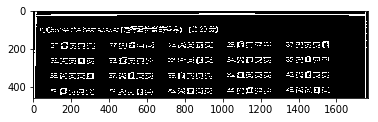

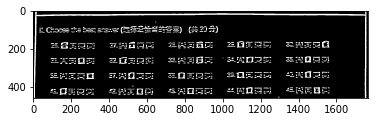

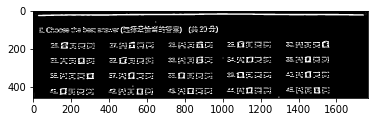

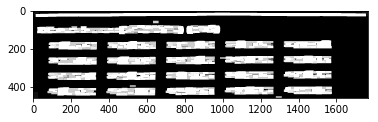

y mean --> 265.7142857142857
y std --> 97.80697358385369
[[71, 807, 52, 182], [158, 80, 47, 260], [156, 390, 48, 261], [155, 701, 48, 260], [153, 1010, 46, 259], [151, 1320, 48, 257], [240, 79, 45, 259], [237, 388, 47, 261], [234, 699, 49, 262], [235, 984, 45, 286], [233, 1319, 45, 256], [321, 76, 44, 259], [317, 386, 48, 263], [317, 698, 46, 262], [315, 1009, 45, 261], [311, 1319, 47, 257], [399, 74, 48, 261], [388, 384, 59, 263], [399, 697, 46, 262], [395, 1008, 47, 262], [395, 1320, 46, 258]]
{45: [395, 1320, 46, 258], 44: [395, 1008, 47, 262], 43: [399, 697, 46, 262], 42: [388, 384, 59, 263], 41: [399, 74, 48, 261], 40: [311, 1319, 47, 257], 39: [315, 1009, 45, 261], 38: [317, 698, 46, 262], 37: [317, 386, 48, 263], 36: [321, 76, 44, 259], 35: [233, 1319, 45, 256], 34: [235, 984, 45, 286], 33: [234, 699, 49, 262], 32: [237, 388, 47, 261], 31: [240, 79, 45, 259], 30: [151, 1320, 48, 257], 29: [153, 1010, 46, 259], 28: [155, 701, 48, 260], 27: [156, 390, 48, 261], 26: [158, 80, 47, 2

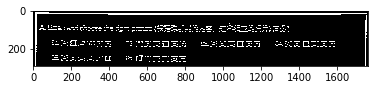

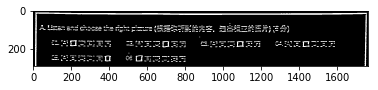

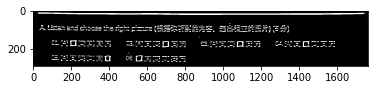

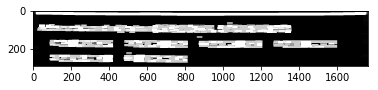

y mean --> 174.33333333333334
y std --> 32.90221201614803
[[148, 84, 45, 340], [151, 477, 46, 340], [153, 868, 43, 341], [153, 1260, 42, 341], [227, 84, 44, 340], [214, 474, 59, 342]]
{6: [214, 474, 59, 342], 5: [227, 84, 44, 340], 4: [153, 1260, 42, 341], 3: [153, 868, 43, 341], 2: [151, 477, 46, 340], 1: [148, 84, 45, 340]}


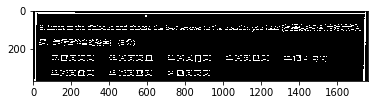

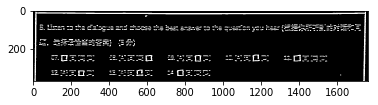

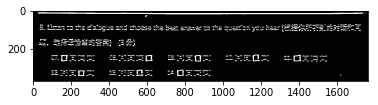

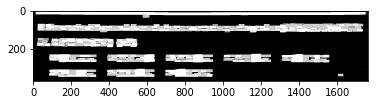

y mean --> 256.5
y std --> 37.58324094593227
[[228, 82, 45, 255], [228, 388, 45, 255], [228, 695, 46, 254], [226, 1000, 47, 255], [227, 1306, 47, 256], [307, 82, 43, 253], [304, 387, 45, 255], [304, 694, 45, 254]]
{14: [304, 694, 45, 254], 13: [304, 387, 45, 255], 12: [307, 82, 43, 253], 11: [227, 1306, 47, 256], 10: [226, 1000, 47, 255], 9: [228, 695, 46, 254], 8: [228, 388, 45, 255], 7: [228, 82, 45, 255]}


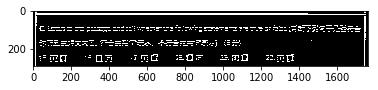

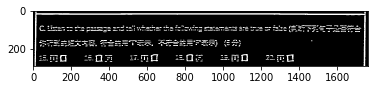

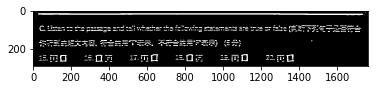

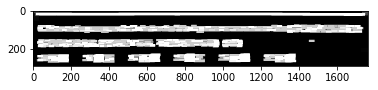

y mean --> 222.16666666666666
y std --> 1.7716909687891083
[[225, 18, 48, 173], [224, 257, 49, 174], [221, 497, 51, 176], [221, 736, 50, 172], [220, 972, 51, 174], [222, 1211, 51, 176]]
{20: [222, 1211, 51, 176], 19: [220, 972, 51, 174], 18: [221, 736, 50, 172], 17: [221, 497, 51, 176], 16: [224, 257, 49, 174], 15: [225, 18, 48, 173]}


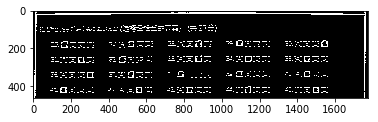

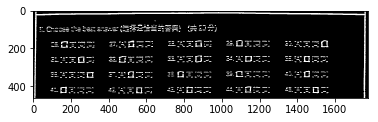

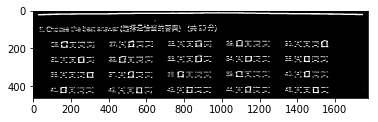

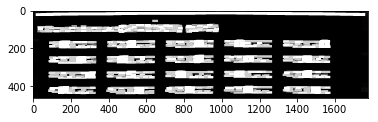

y mean --> 265.85714285714283
y std --> 98.59502823082276
[[70, 806, 52, 182], [158, 83, 46, 256], [155, 391, 48, 259], [154, 701, 47, 259], [152, 1011, 47, 258], [153, 1321, 48, 258], [239, 80, 45, 258], [235, 388, 48, 260], [232, 699, 49, 260], [235, 1010, 44, 259], [235, 1321, 45, 256], [319, 80, 44, 256], [316, 387, 47, 260], [315, 699, 46, 260], [315, 1009, 45, 260], [313, 1320, 47, 258], [397, 78, 47, 257], [400, 386, 44, 260], [397, 697, 46, 261], [395, 1009, 46, 260], [398, 1321, 45, 258]]
{45: [398, 1321, 45, 258], 44: [395, 1009, 46, 260], 43: [397, 697, 46, 261], 42: [400, 386, 44, 260], 41: [397, 78, 47, 257], 40: [313, 1320, 47, 258], 39: [315, 1009, 45, 260], 38: [315, 699, 46, 260], 37: [316, 387, 47, 260], 36: [319, 80, 44, 256], 35: [235, 1321, 45, 256], 34: [235, 1010, 44, 259], 33: [232, 699, 49, 260], 32: [235, 388, 48, 260], 31: [239, 80, 45, 258], 30: [153, 1321, 48, 258], 29: [152, 1011, 47, 258], 28: [154, 701, 47, 259], 27: [155, 391, 48, 259], 26: [158, 83, 46

In [133]:
# 读取数据
from common.examdetect import EXDetect
clip_path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\'

# moible define
qlists = [0,1,2,4]
qdefines = {0:[1, 2, 3, 4, 5, 6],1:[7,8,9,10,11,12,13,14],2:[15, 16, 17, 18, 19, 20],
            4:[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]}
answerdefines = { 
    1:'A-CDEF',2:'ABC-EF',3:'ABC-EF',4:'AB-DEF',5:'ABCDE-',6:'-BCDEF',7:'-BCD',8:'ABC-',
    9:'AB-D',10:'AB-D',11:'-BCD',12:'AB-D',13:'AB-D',14:'-BCD',15:'T-',16:'-F',17:'T-',
    18:'-F',19:'T-',20:'T-',26:'-BCD',27:'A-CD',28:'AB-D',29:'-BCD',30:'ABC-',31:'AB-D',
    32:'-BCD',33:'AB-D',34:'A-CD',35:'A-CD',36:'ABC-',37:'A-CD',38:'-BCD',39:'-BCD',40:'A-CD',
    41:'-BCD',42:'AB-D',43:'A-CD',44:'A-CD',45:'AB-D'
}


# mobile3 define
# qlists = [0,1]
# qdefines = {0:[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93],1:[94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105]}
# answerdefines = {82:'-BCDE',83:'-BCDE',84:'ABCD-',85:'-BCDE',86:'A-CDE',87:'ABC-E',
#                  88:'A-CDE',89:'A-CDE',90:'-BCDE',91:'ABCD-',92:'ABC-E',93:'ABCD-',
#                  94:'--CDE',95:'-BCD-',96:'AB-D-',97:'A-CDE',98:'AB-DE',99:'A--D-',
#                  100:'-BCDE',101:'A-CD-',102:'AB-DE',103:'ABC-E',104:'A--DE',105:'-BCDE'
#                 }


# filename = '乐视2max'
path = 'D:\\PROJECT_TW\\examrc\\data\\exam\\mobile\\'

file_list = os.listdir(path)
file_list = [x for x in file_list if x.endswith('jpg')]

for item in file_list:
    filename = item.split('.')[0]
    print('------------ 开始处理 {} -----------------'.format(filename))
    with  open('{}{}'.format(path,item),'rb') as f:
        imgb = f.read()
    image_bin = np.frombuffer(imgb, np.uint8)    
    exd = EXDetect(id=1, image=image_bin, mobile_type='default')
    # 分隔试卷，取出包含选择题的项
    regions = exd.clip_exam()

    for qidx in qlists:
        y,x,h,w = regions[qidx]
        rect_list = get_text_rect(exd.origin_image[y:y+h,x:x+w])
        cv2.imwrite('d:\\clip_11.jpg',exd.origin_image[y:y+h,x:x+w])
        rect_list = text_rect_sort(rect_list)
        print(rect_list)
        answers = answer_bind_rect(rect_list, qdefines[qidx])
        print(answers)
        for ans_no in answers.keys():
            ay,ax,ah,aw = answers[ans_no]
            rimg = exd.origin_image[y+ay:y+ay+ah, x+ax:x+ax+aw]
            with open('{}{}_{}_{}.jpg'.format(clip_path,filename,ans_no,answerdefines[ans_no]),'wb') as f:
                imgbin = cv2.imencode('.jpg',rimg)[1]
                f.write(imgbin)
            
    


In [6]:
# 从文本框提取字符
import time
clip_path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\clip\\'
clip_save_path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\char\\'
clip_file_name = '23_A-CD'
b_number = 0
n_number = 0

files = os.listdir(clip_path)
# files = ['360n4s_17_T-.jpg',]
start_time = time.time()
for file in files:
    clip_file_name = file.split('.')[0]
    print(clip_file_name)
    image = cv2.imread('{}{}.jpg'.format(clip_path,clip_file_name),cv2.IMREAD_COLOR)
#     print(image.shape)
    cnts = get_char_rect(image)
    cnts_array = np.array(cnts)
    cnts_inx = np.lexsort([cnts_array[:,1]])
    cnts_array = cnts_array[cnts_inx]
    cnts = cnts_array.tolist()
    if len(cnts) < (len(clip_file_name.split('_')[-1])):
        raise Exception('{} 切割失败 切割长度 {} 最少长度 {}'.format(clip_file_name,len(cnts), 
                                                         (len(clip_file_name.split('_')[-1]) + 1)))
    
    binx = [idx for idx,x in enumerate(clip_file_name.split('_')[-1]) if x =='-']
    # 取坐标后几位
    cnts = cnts[len(cnts)-len(clip_file_name.split('_')[-1]):]
    for i, (y,x,h,w) in enumerate(cnts):
        crop_img = image[y:y+h,x:x+w]
        if i in binx:
            cv2.imwrite('{}1_{}.jpg'.format(clip_save_path,b_number),crop_img)
            b_number = b_number + 1
        else:
            cv2.imwrite('{}0_{}.jpg'.format(clip_save_path,n_number),crop_img)
            n_number = n_number + 1

print('total files {}  time {:.4f}'.format(len(files),(time.time() - start_time)))
    
        

360n4s_10_AB-D
360n4s_11_-BCD
360n4s_12_AB-D
360n4s_13_AB-D
360n4s_14_-BCD
360n4s_15_T-
360n4s_16_-F
360n4s_17_T-
360n4s_18_-F
360n4s_19_T-
360n4s_1_A-CDEF
360n4s_20_T-
360n4s_26_-BCD
360n4s_27_A-CD
360n4s_28_AB-D
360n4s_29_-BCD
360n4s_2_ABC-EF
360n4s_30_ABC-
360n4s_31_AB-D
360n4s_32_-BCD
360n4s_33_AB-D
360n4s_34_A-CD
360n4s_35_A-CD
360n4s_36_ABC-
360n4s_37_A-CD
360n4s_38_-BCD
360n4s_39_-BCD
360n4s_3_ABC-EF
360n4s_40_A-CD
360n4s_41_-BCD
360n4s_42_AB-D
360n4s_43_A-CD
360n4s_44_A-CD
360n4s_45_AB-D
360n4s_4_AB-DEF
360n4s_5_ABCDE-
360n4s_6_-BCDEF
360n4s_7_-BCD
360n4s_8_ABC-
360n4s_9_AB-D
iphone6p_10_AB-D
iphone6p_11_-BCD
iphone6p_12_AB-D
iphone6p_13_AB-D
iphone6p_14_-BCD
iphone6p_15_T-
iphone6p_16_-F
iphone6p_17_T-
iphone6p_18_-F
iphone6p_19_T-
iphone6p_1_A-CDEF
iphone6p_20_T-
iphone6p_26_-BCD
iphone6p_27_A-CD
iphone6p_28_AB-D
iphone6p_29_-BCD
iphone6p_2_ABC-EF
iphone6p_30_ABC-
iphone6p_31_AB-D
iphone6p_32_-BCD
iphone6p_33_AB-D
iphone6p_34_A-CD
iphone6p_35_A-CD
iphone6p_36_ABC-
iphone6p_37

Exception: iphone8P_100_-BCDE 切割失败 切割长度 3 最少长度 6

# 数据准备

In [3]:
# https://github.com/pytorch/vision/issues/81

# 将图片数据写入到LMDB数据库存中

import lmdb
import glob
# 创建数据库
# import lmdb  # install lmdb by "pip install lmdb"
# env = lmdb.open('./data/lmdb', map_size=511627776)
# env = lmdb.open('./data/lmdb', map_size=511627776)
# from genLineText import GenTextImage
def checkImageIsValid(imageBin):
    if imageBin is None:
        return False
    
    imageBuf = np.frombuffer(imageBin, dtype=np.uint8)
    img = cv2.imdecode(imageBuf, cv2.IMREAD_COLOR)
    if img is None:
        return False
    imgH, imgW = img.shape[0], img.shape[1]
    if imgH * imgW == 0:
        return False
    return True

def writeCache(env, cache):
    with env.begin(write=True) as txn:
        for k, v in cache.items():
            txn.put(k.encode(), v)
            
def createDataset(outputPath, imagePathList, labelList, lexiconList=None, checkValid=True):
    """
    Create LMDB dataset for CRNN training.
    ARGS:
        outputPath    : LMDB output path
        imagePathList : list of image path
        labelList     : list of corresponding groundtruth texts
        lexiconList   : (optional) list of lexicon lists
        checkValid    : if true, check the validity of every image
    """
    # print (len(imagePathList) , len(labelList))
    assert (len(imagePathList) == len(labelList))
    nSamples = len(imagePathList)
    
    env = lmdb.open(outputPath, map_size=511627776)

    cache = {}
    cnt = 1
    for i in range(nSamples):
        imagePath = imagePathList[i]
        label = labelList[i]
        if not os.path.exists(imagePath):
            print('%s does not exist' % imagePath)
            continue
        with open(imagePath, 'rb') as f:
            imageBin = f.read()
        
        if checkValid:
            if not checkImageIsValid(imageBin):
                print('%s is not a valid image' % imagePath)
                continue

        imageKey = 'image-%09d' % cnt
        labelKey = 'label-%09d' % cnt
        cache[imageKey] = imageBin
        cache[labelKey] = label.encode()
        if lexiconList:
            lexiconKey = 'lexicon-%09d' % cnt
            cache[lexiconKey] = ' '.join(lexiconList[i]).encode()
        if cnt % 1000 == 0:
            writeCache(env, cache)
            cache = {}
            print('Written %d / %d' % (cnt, nSamples))
        cnt += 1
    nSamples = cnt - 1
    cache['num-samples'] = str(nSamples).encode()
    writeCache(env, cache)
    print('Created dataset with %d samples' % nSamples)


def read_text(path):
    with open(path) as f:
        text = f.read()
    text = text.strip()

    return text

# outputPath = './data/lmdb/train'   # 训练数据
outputPath = 'D:\\PROJECT_TW\\git\\data\\example\\lmdb'   # 测试数据
path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\char\\*.jpg'
imagePathList = glob.glob(path)
imgLabelLists = []
for p in imagePathList:
    try:
        label = p.split('\\')[-1].split('_')[0]
        imgLabelLists.append((p,label))
    except:
        continue

imgLabelList = sorted(imgLabelLists, key=lambda x: len(x[1]))
imgPaths = [p[0] for p in imgLabelList]
txtLists = [p[1] for p in imgLabelList]
createDataset(outputPath, imgPaths, txtLists, lexiconList=None, checkValid=True)

Created dataset with 74 samples


In [2]:
# 加载数据
# 注意 dataset.alignCollate 将图片转成了灰度图，后期看怎么修改一下。
# collate_fn，是用来处理不同情况下的输入dataset的封装，一般采用默认即可，除非你自定义的数据读取输出非常少见
import common.dataset as dataset
path = 'D:\\PROJECT_TW\\git\\data\\example\\lmdb'
train_dataset = dataset.lmdbDataset(root=path, transform=dataset.resizeNormalize((32,32)))
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    sampler=None
#     collate_fn=dataset.alignCollate(imgH=32, imgW=32, keep_ratio=False)
)

# dataset 方法resizeNormalize 中用了transforms.ToTensor 会将数据做归一化处理，在正式用的时候也需要将数据调用该方法做归一化处理

# 可参看 https://blog.csdn.net/victoriaw/article/details/72822005 数据预处理torchvision.transforms 


In [3]:
for idx,v in enumerate(train_loader):
#     print(idx,v)
#     print(v)
    pass
# print(v)
print(idx)
# print(np.array(v[0]).shape)

36


# 数据模型

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_1 = nn.Sequential(         # input shape (1, 32, 32)
            nn.Conv2d(
                in_channels=3,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 16, 16)
        )        
        
        self.conv_2 = nn.Sequential(         # input shape (16, 16, 16)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 16, 16)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 8, 8)
        )        
        
        self.out = nn.Linear(32 * 8 * 8, 2)   # fully connected layer, output 2 classes
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 8 * 8)
        output = self.out(x)
        return output       # return x for visualization    
        

# 训练

In [7]:
# https://blog.csdn.net/tianweidadada/article/details/82630735   用 pytorch 进行分类（二分类，多分类）
net = CNN()
opitmizer = torch.optim.SGD(net.parameters(),lr=0.01)
loss_fun = nn.MSELoss() 
epoches = 1000


for i in range(epoches):
    for step, values in enumerate(train_loader):
        images = values[0]
        # 二分类，target 在做损失的时候需要（0，1），（1，0）这样的格式
        target = [ [1-int(x),int(x) ] for x in values[1]]
        target =  Variable(torch.FloatTensor(target)) #变成 1*2的 tensor
        preds = F.softmax(net(images),dim=1)
        loss = loss_fun(preds,target)
        opitmizer.zero_grad()
        loss.backward()
        opitmizer.step()
    if i%100 == 0:
        print('loss --> {:.4f}'.format(loss))


loss --> 0.0226
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000
loss --> 0.0000


# 验证

In [20]:
import torchvision.transforms as transforms 
import time
path = 'D:\\PROJECT_TW\\git\\data\\example\\image\\char\\1_15.jpg'
image = cv2.imread(path,cv2.IMREAD_COLOR)    
if image.shape[0] != 32 or image.shape[1] != 32:
    image = cv2.resize(image,(32,32))
# aa[np.newaxis,:].shape, newaxis增加维度
# np.r_[bb,bb].shape 添加行数据
# image = image[np.newaxis,:]
print(image.shape)

start_time = time.time()
for _ in range(1):

    imdata = transforms.ToTensor()(image)
    imdata = imdata.unsqueeze(0)
#     print(imdata.size())
    preds = net(imdata)
    preds = F.softmax(preds,dim=1)
    print(preds)
    
print('time --> {}'.format((time.time()-start_time)))


(32, 32, 3)
tensor([[ 0.0027,  0.9973]])
time --> 0.06861186027526855
